# Imports

In [1]:
import torch
import os
import numpy as np
from matplotlib import pyplot as plt
import warnings
import scipy.optimize as opt
warnings.filterwarnings("ignore")

from utils.image_helpers import load_images, plot_image_grid, show_images, rgb2gray
from utils.configuration_parser.fit_model_configuration import get_fit_model_configuration
from models.model_creation import create_model_from_configuration
from fitting.Fitter import create_fitter_from_configuration
from simulation.Simulation import Simulation
from utils.evaluation_helpers import calculate_full_width_half_maximum_value

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    os.environ['CUDA_VISIBLE_DEVICES'] = '1'
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor

num GPUs 1


# Create Image

In [2]:
def create_vertical_contrast(size):
    return np.concatenate((np.ones((size[0],size[1]//2)), np.zeros((size[0],size[1]//2))), axis=1)

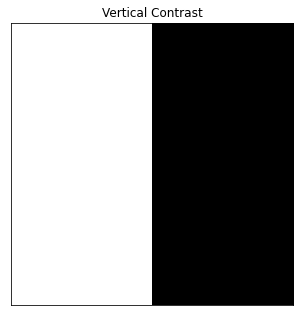

In [3]:
input_size = (256, 256)
vertical_image = create_vertical_contrast(input_size)
plot = plot_image_grid([vertical_image], ['Vertical Contrast'], ncols=1)

# Gibbs Simulation

In [4]:
cnr_range = [2, 4, 8]
number_of_runs_per_cnr = 1

In [5]:
vertical_noisy_images = []
vertical_target_images = []

for cnr in cnr_range:
    sigma = 1/cnr/np.sqrt(2)
    simulation = Simulation(cropped_size=(100, 100), pf_factor=8, noise_sigma=sigma)
    for index in range(number_of_runs_per_cnr):
        vertical_noisy_image, vertical_target_image = simulation(vertical_image)
        vertical_noisy_images.append(vertical_noisy_image)
        vertical_target_images.append(vertical_target_image)
        print(f'{cnr} CNR: {index+1}/{number_of_runs_per_cnr}', end='\r')
    print('')

2 CNR: 1/1
4 CNR: 1/1
8 CNR: 1/1


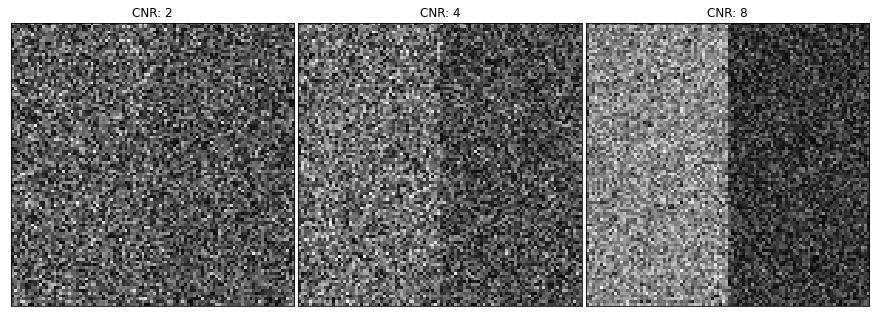

In [6]:
titles = ['CNR: ' + str(x) for x in cnr_range for _ in range(number_of_runs_per_cnr)]
plot = plot_image_grid(vertical_noisy_images, titles, ncols=3)

# Fitting

In [7]:
number_of_runs = 10


fit_model_configuration = get_fit_model_configuration()
fit_model_configuration.model_type = 'deep'
fit_model_configuration.input_shape = [4, 4]
fit_model_configuration.number_of_hidden_channels = 64
fit_model_configuration.number_of_layers = 4
fit_model_configuration.log_frequency = 100
fit_model_configuration.convergence_check_length = 1000
fit_model_configuration.image_dimensions = [100,100,1]
fit_model_configuration.save_losses = False
fit_model_configuration.result_path = None
print(fit_model_configuration)

image_dimensions: [100, 100, 1]  
result_path: None  
model_type: deep  
input_shape: [4, 4]  
number_of_layers: 4  
number_of_hidden_channels: 64  
number_of_iterations: 30000  
learning_rate: 0.1  
convergence_check_length: 1000  
log_frequency: 100  
find_best: True  
save_losses: False  
constant_input: False  
data_type: <class 'torch.cuda.FloatTensor'>  



Step: 06000, Loss: 0.106288, Target Loss: 0.187707, Minimum Loss at: 5003 with 0.017211
Adam has converged at step 6004.
Step: 05400, Loss: 0.106288, Target Loss: 0.187707, Minimum Loss at: 4484 with 0.017854
Adam has converged at step 5485.
Step: 02100, Loss: 0.022187, Target Loss: 0.081720, Minimum Loss at: 1175 with 0.021415
Adam has converged at step 2176.
Step: 06700, Loss: 0.106288, Target Loss: 0.187707, Minimum Loss at: 5773 with 0.018664
Adam has converged at step 6774.
Step: 07000, Loss: 0.106288, Target Loss: 0.187707, Minimum Loss at: 6035 with 0.018467
Adam has converged at step 7036.
Step: 06400, Loss: 0.106288, Target Loss: 0.187707, Minimum Loss at: 5484 with 0.017503
Adam has converged at step 6485.
Step: 05800, Loss: 0.106288, Target Loss: 0.187707, Minimum Loss at: 4848 with 0.017236
Adam has converged at step 5849.
Step: 02300, Loss: 0.022433, Target Loss: 0.090103, Minimum Loss at: 1398 with 0.021193
Adam has converged at step 2399.
Step: 06400, Loss: 0.102205, Tar

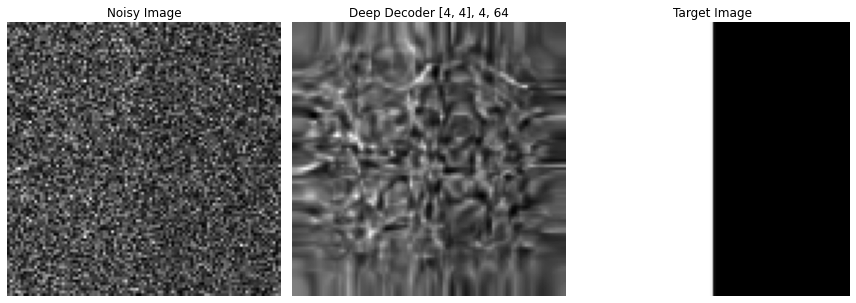

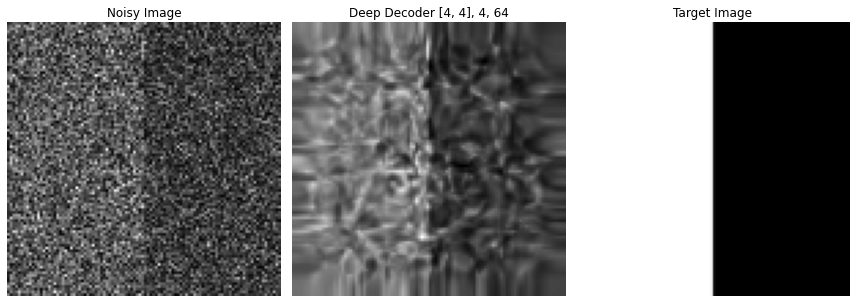

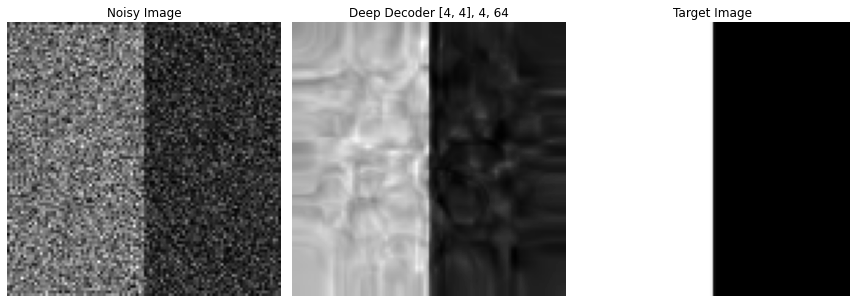

In [8]:
vertical_model_images = []

for vertical_noisy_image, vertical_target_image in zip(vertical_noisy_images, vertical_target_images):
    model_images = []
    for _ in range(number_of_runs):
        model = create_model_from_configuration(fit_model_configuration)
        vertical_fitter = create_fitter_from_configuration(fit_model_configuration)
        vertical_fitter(model, vertical_noisy_image, vertical_target_image)
        model_image = vertical_fitter.get_best_image()
        model_images.append(model_image)
    vertical_model_images.append(np.mean(model_images, axis=0))
    show_images(vertical_noisy_image, vertical_model_images[-1], vertical_target_image, model_description=str(model))

# Calculating FWHMs

In [27]:
def logistic_function(x, alpha, beta, gamma, c):
    return alpha / (1. + np.exp((x - beta) / gamma)) + c


def logistic_sum(x, a1, a2, a3, b1, b2, b3, g1, g2, g3, c):
    alphas = [a1, a2, a3]
    betas = [b1, b2, b3]
    gammas = [g1, g2, g3]
    out = 0.0
    for (alpha, beta, gamma) in zip(alphas, betas, gammas):
        out += logistic_function(x, alpha, beta, gamma)
    out += c
    return out

def calculate_vertical_profile(image):
    columns = np.mean(image, axis=0)
    return columns

(100, 1)


ValueError: object too deep for desired array

error: Result from function call is not a proper array of floats.

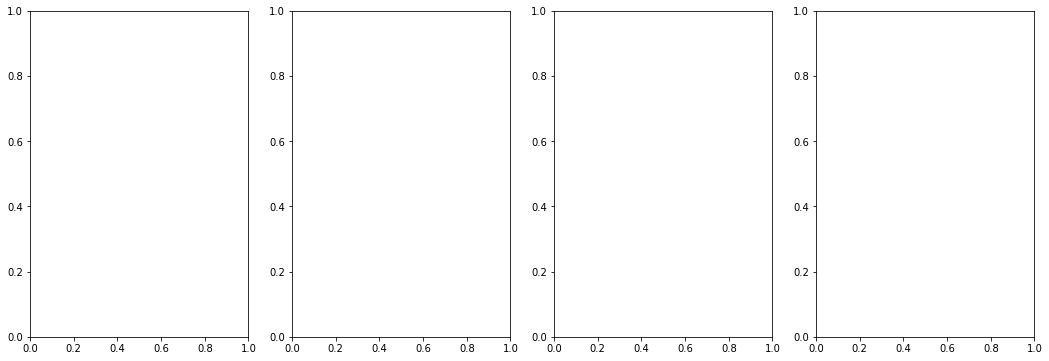

In [42]:
np.seterr(all='ignore')
for vertical_model_image in vertical_model_images:
    figure, axes = plt.subplots(1, 4, figsize=(18, 6))
    fail_counter = 0
    values = []
    # row = calculate_vertical_profile(vertical_model_image)[:,0]
    # axes[0].plot(row, 'o')
    # axes[0].set_title('Average Row')
    for row in vertical_model_image:
        print(row.shape)
        try:
            accuracy_factor = 100
            max_iter= 100000
            number_of_pixels = len(row)
            x = np.linspace(0, number_of_pixels, num=number_of_pixels * accuracy_factor)

            # estimated_parameters = [0.3, 0.3, 0.3,
            #                         number_of_pixels / 2., number_of_pixels / 2., number_of_pixels / 2.,
            #                         1., 1., 1.,
            #                         0]
            # (a1, a2, a3, b1, b2, b3, g1, g2, g3, c), _ = opt.curve_fit(logistic_sum,
            #                                                            np.arange(number_of_pixels),
            #                                                            row,
            #                                                            p0=estimated_parameters,
            #                                                            maxfev=max_iter)
            # alphas = [a1, a2, a3]
            # betas = [b1, b2, b3]
            # gammas = [g1, g2, g3]
            # fitted_row = logistic_sum(x, *alphas, *betas, *gammas, c)

            estimated_parameters = [1.0, number_of_pixels / 2., 1., 0]
            (a, b, g, c), _ = opt.curve_fit(logistic_function, np.arange(number_of_pixels), row, p0=estimated_parameters, maxfev=max_iter)
            fitted_row = logistic_function(x, a, b, g, c)

            axes[0].plot(x, fitted_row)

            differences = -np.diff(fitted_row)
            half_max = np.max(differences)/2.
            indices = np.where(np.diff(np.sign(differences - half_max)))[0]
            value = (indices[-1] - indices[0])/accuracy_factor
            values.append(value)
            axes[1].plot(1, value, 'o')
            axes[1].set_title('Successfully calculated FWHMs')
        except RuntimeError:
            fail_counter += 1
            axes[2].plot(row)
            axes[2].set_title('Rows that could not be fitted')
        except IndexError:
            fail_counter += 1
            axes[3].plot(x, fitted_row)
            axes[3].set_title('Fitted rows without Maximum')
    print('')
    print('Fails:', fail_counter)
    print('FWHM', np.mean(values))